In [1]:
import numpy as np
import string

from collections import Counter
from sklearn.metrics import accuracy_score
from pathlib import Path

from llm_robustness.utils.data import json_to_dataframe


def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation)).lower()


def answer_to_short(text):
    return text.split()[0].strip()


def read_model_results(path):
    df = json_to_dataframe(path)
    df = df.rename(columns={"predicted_answer": "rag_answer"})
    columns_to_clean = [
        "true_answer",
        "vanilla_answer",
        "rag_answer",
        "adversarial_answer",
    ]
    df[columns_to_clean] = df[columns_to_clean].map(remove_punctuation)

    assert df["id"].duplicated().sum() == 0, "There are duplicated ids in the dataframe"
    return df


def read_model_model_results(path):
    df = json_to_dataframe(path)
    columns_to_clean = ["adversarial_answer"]
    df[columns_to_clean] = df[columns_to_clean].map(remove_punctuation)
    assert df["id"].duplicated().sum() == 0, "There are duplicated ids in the dataframe"
    return df


def read_model_extended_results(path):
    df = json_to_dataframe(path)
    columns_to_clean = ["adversarial_answer"]
    df[columns_to_clean] = df[columns_to_clean].map(remove_punctuation)
    df["adversarial_answer_short"] = df["adversarial_answer"].map(answer_to_short)
    assert df["id"].duplicated().sum() == 0, "There are duplicated ids in the dataframe"
    return df


def attack_success_rate(true_answers, vanilla_answers, adversarial_answers):
    assert (
        len(true_answers) == len(vanilla_answers) == len(adversarial_answers)
    ), "The lengths of the lists are not equal"
    return sum(
        ta == va and ta != aa
        for ta, va, aa in zip(true_answers, vanilla_answers, adversarial_answers)
    ) / len(vanilla_answers)

In [2]:
IN_FILE = Path(
    "../../../data/results/binary_questions_adversarial_gemma9b_gemma9b.json"
)
df_gemma = read_model_results(IN_FILE)
print(f"Class distribution: {Counter(df_gemma.true_answer)}")

IN_FILE = Path(
    "../../../data/results/binary_questions_adversarial_gemma9b_llama70b.json"
)
df_llama = read_model_model_results(IN_FILE)

IN_FILE = Path(
    "../../../data/results/binary_questions_adversarial_gemma9b_mixtral.json"
)
df_mixtral = read_model_model_results(IN_FILE)

IN_FILE = Path(
    "../../../data/results/binary_questions_adversarial_gemma9b_gpt4o_extended.json"
)
df_gpt4o = read_model_extended_results(IN_FILE)

vanilla_acc = accuracy_score(
    y_true=df_gemma.true_answer, y_pred=df_gemma.vanilla_answer
)
rag_acc = accuracy_score(y_true=df_gemma.true_answer, y_pred=df_gemma.rag_answer)
adversarial_gemma_acc = accuracy_score(
    y_true=df_gemma.true_answer,
    y_pred=df_gemma.adversarial_answer,
)
adversarial_mixtral_acc = accuracy_score(
    y_true=df_gemma[df_gemma["id"].isin(df_mixtral["id"])].true_answer,
    y_pred=df_mixtral.adversarial_answer,
)
adversarial_llama_acc = accuracy_score(
    y_true=df_gemma[df_gemma["id"].isin(df_llama["id"])].true_answer,
    y_pred=df_llama.adversarial_answer,
)

adversarial_gpt_acc = accuracy_score(
    y_true=df_gemma[df_gemma["id"].isin(df_gpt4o["id"])].true_answer,
    y_pred=df_gpt4o.adversarial_answer_short,
)

asr_gemma = attack_success_rate(
    df_gemma.true_answer,
    df_gemma.vanilla_answer,
    df_gemma.adversarial_answer,
)

asr_mixtral = attack_success_rate(
    df_gemma[df_gemma["id"].isin(df_mixtral["id"])].true_answer,
    df_gemma[df_gemma["id"].isin(df_mixtral["id"])].vanilla_answer,
    df_mixtral.adversarial_answer,
)

asr_llama = attack_success_rate(
    df_gemma[df_gemma["id"].isin(df_llama["id"])].true_answer,
    df_gemma[df_gemma["id"].isin(df_llama["id"])].vanilla_answer,
    df_llama.adversarial_answer,
)

asr_gpt4o = attack_success_rate(
    df_gemma[df_gemma["id"].isin(df_gpt4o["id"])].true_answer,
    df_gemma[df_gemma["id"].isin(df_gpt4o["id"])].vanilla_answer,
    df_gpt4o.adversarial_answer_short,
)

assert (
    set(df_gemma.true_answer)
    == set(df_gemma.rag_answer)
    == set(df_gemma.vanilla_answer)
    == set(df_llama.adversarial_answer)
    == set(df_gemma.adversarial_answer)
    == set(df_mixtral.adversarial_answer)
    == set(df_gpt4o.adversarial_answer_short)
), "The answers are not the same across all dataframes"

Class distribution: Counter({'yes': 1002, 'no': 354})


In [3]:
print(f"Number of questions:\t\t {len(df_gemma)}\n")
print(f"Vanilla Gemma accuracy:\t\t {vanilla_acc:.3f}")
print(f"RAG Gemma accuracy:\t\t {rag_acc:.3f}")
print(f"Advers. Gemma RAG accuracy:\t {adversarial_gemma_acc:.3f}")
print(f"Advers. Mixtral RAG accuracy:\t {adversarial_mixtral_acc:.3f}")
print(f"Advers. Llama RAG accuracy:\t {adversarial_llama_acc:.3f}")
print(f"Advers. GPT4o RAG accuracy:\t {adversarial_gpt_acc:.3f}")
print(f"ASR Gemma:\t\t\t {asr_gemma:.3f}")
print(f"ASR Mixtral:\t\t\t {asr_mixtral:.3f}")
print(f"ASR Llama:\t\t\t {asr_llama:.3f}")
print(f"ASR GPT4o:\t\t\t {asr_gpt4o:.3f}")
print(f"ASR avg.:\t\t\t {np.mean([asr_gemma, asr_mixtral, asr_llama, asr_gpt4o]):.3f}")

Number of questions:		 1356

Vanilla Gemma accuracy:		 0.810
RAG Gemma accuracy:		 0.957
Advers. Gemma RAG accuracy:	 0.367
Advers. Mixtral RAG accuracy:	 0.316
Advers. Llama RAG accuracy:	 0.326
Advers. GPT4o RAG accuracy:	 0.344
ASR Gemma:			 0.500
ASR Mixtral:			 0.552
ASR Llama:			 0.546
ASR GPT4o:			 0.527
ASR avg.:			 0.531


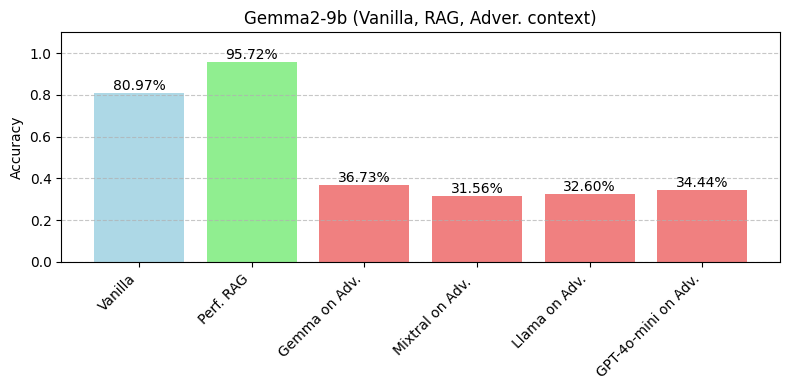

In [4]:
import matplotlib.pyplot as plt

# Assuming you've already calculated these accuracy scores
accuracies = [
    vanilla_acc,
    rag_acc,
    adversarial_gemma_acc,
    adversarial_mixtral_acc,
    adversarial_llama_acc,
    adversarial_gpt_acc,
]

labels = [
    "Vanilla",
    "Perf. RAG",
    "Gemma on Adv.",
    "Mixtral on Adv. ",
    "Llama on Adv.",
    "GPT-4o-mini on Adv.",
]
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(
    labels, accuracies, color=["lightblue", "lightgreen"] + ["lightcoral"] * 4
)
ax.set_ylim(0, 1.1)
ax.set_title("Gemma2-9b (Vanilla, RAG, Adver. context)")
ax.set_ylabel("Accuracy")
for i, v in enumerate(accuracies):
    ax.text(i, v, f"{v:.2%}", ha="center", va="bottom")
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
# plt.savefig("accuracy_comparison.png", dpi=300)
plt.show()